In [2]:
import pandas as pd, re, numpy as np, collections

In [3]:
fd = "/Users/druc594/Library/CloudStorage/OneDrive-PNNL/Desktop/DeepKS_/DeepKS/data/raw_data/raw_data_45176_formatted_65.csv"
# fd = "/Users/druc594/Library/CloudStorage/OneDrive-PNNL/Desktop/DeepKS_/DeepKS/data/raw_data_31834_formatted_65_26610.csv"
fddf = pd.read_csv(fd)
kin_fam_grp = "/Users/druc594/Library/CloudStorage/OneDrive-PNNL/Desktop/DeepKS_/DeepKS/data/preprocessing/kin_to_fam_to_grp_826.csv"
kin_to_grp_df = pd.read_csv(kin_fam_grp)[["Kinase", "Uniprot", "Group"]]
kin_to_grp_df["Symbol"] = (
    kin_to_grp_df["Kinase"].apply(lambda x: re.sub(r"[\(\)\*]", "", x)) + "|" + kin_to_grp_df["Uniprot"]
)
kin_to_grp = kin_to_grp_df.set_index("Symbol").to_dict()["Group"]
site_to_grp = collections.defaultdict(set)
for i, r in fddf.iterrows():
    site_to_grp[r['Site Sequence']].add(kin_to_grp[r['Gene Name of Kin Corring to Provided Sub Seq']])

In [43]:
site_to_grp['XXXMKALSPVRGCYE']

{'CMGC', 'TK'}

In [4]:
import logomaker, matplotlib.pyplot as plt

Fontconfig warning: ignoring UTF-8: not a valid region tag


In [5]:
num_aa = 21
seq_len = 15
aas = list("ACDEFGHIKLMNPQRSTVWYX")

def one_hot_aa_embedding(seq):
    assert len(seq) == seq_len
    patch = np.zeros((len(seq), num_aa))
    aa_dict = {aa: i for i, aa in enumerate(aas)}
    for i, aa in enumerate(seq):
        patch[i, aa_dict[aa]] = 1
    embedding = patch.ravel()
    return embedding

In [6]:
np.random.seed(42)
sample_inds = np.random.choice(len(site_to_grp), len(site_to_grp), replace=False)
X = np.array([one_hot_aa_embedding(seq) for seq in site_to_grp])[sample_inds]
y = np.array([site_to_grp[s] for s in site_to_grp.keys()])[sample_inds]
# y_to_int = {yv: i for i, yv in enumerate(sorted(list(set(y)), reverse=True))}

In [7]:
from sklearn.cluster import KMeans
wss = []
n_clusters_to_try = [6]
for n_clusters in n_clusters_to_try:
    print(n_clusters)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    wss.append(kmeans.inertia_)

6


/Users/druc594/miniforge3/envs/py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [8]:
# Make a t-sne plot
from sklearn.manifold import TSNE
np.random.seed(42)

tsne = TSNE(n_components=2, random_state=42, perplexity=100)
# train tsne:
X_embedded = tsne.fit_transform(X)

KeyboardInterrupt: 

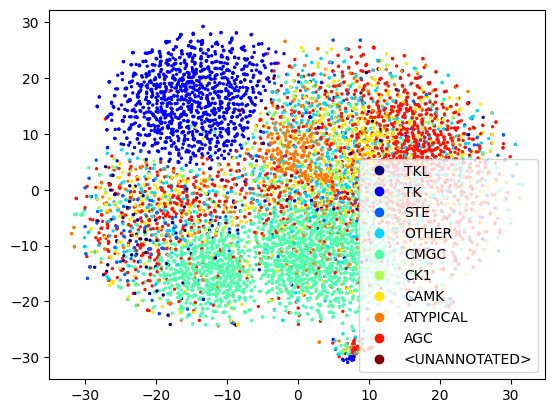

In [ ]:
from matplotlib.colors import ListedColormap
# Use tab10 colormap instead
cmap = plt.cm.jet
sca = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=2, c=[y_to_int[yi] for yi in y], alpha=1, cmap=cmap)

plt.legend(handles=sca.legend_elements()[0], labels=list(y_to_int.keys()))
plt.show()

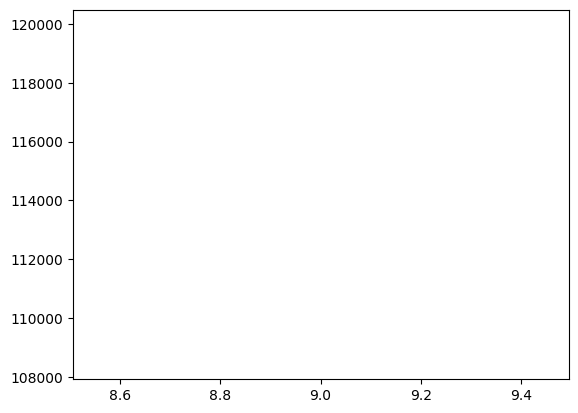

In [ ]:
%matplotlib inline
plt.plot(n_clusters_to_try, wss)
plt.show()

In [9]:
# Compare to the original groups

all_labs = sorted(list(set([yv for yi in y for yv in yi])))

preds = kmeans.predict(X)
val_mtx = pd.DataFrame(
    index=all_labs,
    columns=list(range(n_clusters)),
    data=np.zeros(
        (len(all_labs), n_clusters_to_try[0]),
    ),
)
for x, yi in zip(preds, y):
    for yorig in yi:
        val_mtx.loc[yorig, x] = val_mtx.loc[yorig, x] + 1

val_mtx.loc["Totals"] = val_mtx.sum(axis=0)
val_mtx.loc[:, "Totals"] = val_mtx.sum(axis=1)
row_totals = val_mtx.loc[:, "Totals"].iloc[:-1]
col_totals = val_mtx.loc["Totals", :].iloc[:-1]
val_mtx = val_mtx.astype(int)


In [10]:
proto_tk = "ACDEFGHYHIKLMNP"
proto_tk_embedded = one_hot_aa_embedding(proto_tk)
kmeans.predict([proto_tk_embedded])

array([5], dtype=int32)

In [11]:
# normalize val_mtx rows:
val_mtx_norm = 2*val_mtx.div(val_mtx.sum(axis=1), axis=0)
val_mtx_norm

,0,1,2,3,4,5,Totals
<UNANNOTATED>,0.000000,0.480769,0.057692,0.326923,0.000000,0.134615,1.0
AGC,0.033096,0.364051,0.322397,0.216262,0.062197,0.001997,1.0
ATYPICAL,0.105568,0.520882,0.040603,0.197216,0.124130,0.011601,1.0
CAMK,0.044033,0.339502,0.340140,0.209955,0.059349,0.007020,1.0
CK1,0.057971,0.596618,0.031401,0.169082,0.135266,0.009662,1.0
CMGC,0.336813,0.218047,0.044769,0.268151,0.125261,0.006959,1.0
OTHER,0.056856,0.521739,0.072910,0.234114,0.099666,0.014716,1.0
STE,0.059406,0.344554,0.122772,0.388119,0.045545,0.039604,1.0
TK,0.007339,0.014188,0.005871,0.009295,0.001468,0.961840,1.0
TKL,0.060790,0.361702,0.079027,0.428571,0.042553,0.027356,1.0


In [12]:
val_mtx

,0,1,2,3,4,5,Totals
<UNANNOTATED>,0,25,3,17,0,7,52
AGC,116,1276,1130,758,218,7,3505
ATYPICAL,91,449,35,170,107,10,862
CAMK,69,532,533,329,93,11,1567
CK1,24,247,13,70,56,4,414
CMGC,1452,940,193,1156,540,30,4311
OTHER,85,780,109,350,149,22,1495
STE,30,174,62,196,23,20,505
TK,15,29,12,19,3,1966,2044
TKL,20,119,26,141,14,9,329


In [13]:
vm = val_mtx_norm.drop('Totals', axis=1, inplace=False)
vm = vm.drop('Totals', axis=0, inplace=False)
top_n_origes = {}
for col in vm.columns:
    top_n_origes[col] = vm[col].sort_values(ascending=False, inplace=False).head(2).index.tolist()

In [14]:
new_labels = [f"New-Grp-{i}-{'-'.join(v)}" for i, v in top_n_origes.items()]

grp_to_new_label = dict(zip(list(range(len(new_labels))), new_labels))

In [15]:
grp_to_new_label

{0: 'New-Grp-0-CMGC-ATYPICAL',
 1: 'New-Grp-1-CK1-OTHER',
 2: 'New-Grp-2-CAMK-AGC',
 3: 'New-Grp-3-TKL-STE',
 4: 'New-Grp-4-CK1-CMGC',
 5: 'New-Grp-5-TK-<UNANNOTATED>'}

In [16]:
from sklearn.cluster import KMeans

class NamedKMeans(KMeans):
    def __init__(self, n_clusters, cluster_names, **kwargs):
        super().__init__(n_clusters=n_clusters, **kwargs)
        self.cluster_names = cluster_names
    
    def predict(self, X):
        labels = super().predict(X)
        named_labels = [self.cluster_names[label] for label in labels]
        return named_labels

In [17]:
n_clusters = 6
kmeans_labeled = NamedKMeans(n_clusters=n_clusters, cluster_names=[grp_to_new_label[i] for i in range(6)], random_state=42)

In [18]:
kmeans_labeled.fit(X)

/Users/druc594/miniforge3/envs/py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


NamedKMeans(cluster_names=['New-Grp-0-CMGC-ATYPICAL', 'New-Grp-1-CK1-OTHER',
                           'New-Grp-2-CAMK-AGC', 'New-Grp-3-TKL-STE',
                           'New-Grp-4-CK1-CMGC', 'New-Grp-5-TK-<UNANNOTATED>'],
            n_clusters=6)

In [19]:
kmeans_labeled.predict([proto_tk_embedded])

['New-Grp-5-TK-<UNANNOTATED>']

In [20]:
from random import sample


preds = kmeans_labeled.predict(X)
seqs_to_new_classes = dict(zip(np.array(list(site_to_grp.keys()))[sample_inds], preds))

In [ ]:
import jsonpickle
with open("json-serialized-kmeans-model-train-dat-only.json", "w") as f:
    s = str(jsonpickle.encode(kmeans_labeled, indent=2))
    f.write(s)


In [21]:
import json


with open("/Users/druc594/Library/CloudStorage/OneDrive-PNNL/Desktop/DeepKS_/DeepKS/discovery/nature_atlas/issue28B/site-info.json") as f:
    site_info = json.load(f)

In [ ]:
site_info = {k: (v | {"Known Group": seqs_to_new_classes[k]}) for k, v in site_info.items()}


In [ ]:
with open("/Users/druc594/Library/CloudStorage/OneDrive-PNNL/Desktop/DeepKS_/DeepKS/discovery/nature_atlas/issue28B/site-info.json", "w") as f:
    json.dump(site_info, f)

In [41]:
with open(f"../data/preprocessing/site_to_group_{len(seqs_to_new_classes)}.json", "w") as f:
    # seqs_to_new_classes_tk_mod = {k: v if site_to_grp[k] != 'TK' else new_labels[-1] for k, v in seqs_to_new_classes.items()}
    json.dump({k: list(v)[0] for k, v in site_to_grp.items()}, f)

In [38]:
seqs_to_new_classes_tk_mod = {k: v if site_to_grp[k] != {'TK'} else new_labels[-1] for k, v in seqs_to_new_classes.items()}
seqs_to_new_classes_tk_mod = {k: new_labels[0] if v == new_labels[-1] and site_to_grp[k] != {'TK'} else v for k, v in seqs_to_new_classes_tk_mod.items()}

In [39]:
seqs_to_new_classes_tk_mod

{'XXXXMSKSESPKEPE': 'New-Grp-1-CK1-OTHER',
 'RVYKKMPSIESDVXX': 'New-Grp-1-CK1-OTHER',
 'VGTPYYMSPERIHEN': 'New-Grp-0-CMGC-ATYPICAL',
 'ECRRRAQSVSLEGSA': 'New-Grp-2-CAMK-AGC',
 'WGLNKQGYKCRQCNA': 'New-Grp-5-TK-<UNANNOTATED>',
 'APSLEDVTKQYMLNL': 'New-Grp-3-TKL-STE',
 'QCQTESKYDSVSADV': 'New-Grp-0-CMGC-ATYPICAL',
 'PRPDHTKSIYTRSVI': 'New-Grp-1-CK1-OTHER',
 'HDDSSSDSGTPSGPD': 'New-Grp-4-CK1-CMGC',
 'SSSSSSASSYTGRPI': 'New-Grp-4-CK1-CMGC',
 'LSPVRSRSLSFSEPQ': 'New-Grp-2-CAMK-AGC',
 'IQGGAFESPKKEKRP': 'New-Grp-0-CMGC-ATYPICAL',
 'LRDGQLVSQRAIPPR': 'New-Grp-1-CK1-OTHER',
 'TSLVEGRSCGWVPPP': 'New-Grp-1-CK1-OTHER',
 'FHPNVSSSHENLEPE': 'New-Grp-1-CK1-OTHER',
 'KLQLRVPSVESLFRS': 'New-Grp-2-CAMK-AGC',
 'GGYGGSSSSSSYGSG': 'New-Grp-1-CK1-OTHER',
 'PFPNLGPSENPLKRL': 'New-Grp-1-CK1-OTHER',
 'GPVRLHSSNPNLSTL': 'New-Grp-1-CK1-OTHER',
 'RGTASRSTFHGQPRE': 'New-Grp-3-TKL-STE',
 'YTLLNENYVEDDDNM': 'New-Grp-5-TK-<UNANNOTATED>',
 'EEEGAPDYENLQELN': 'New-Grp-5-TK-<UNANNOTATED>',
 'EDSQDDESDSDAEEE': 'New-Grp-1

/Users/druc594/miniforge3/envs/py311/lib/python3.11/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


/Users/druc594/miniforge3/envs/py311/lib/python3.11/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


/Users/druc594/miniforge3/envs/py311/lib/python3.11/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


/Users/druc594/miniforge3/envs/py311/lib/python3.11/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


/Users/druc594/miniforge3/envs/py311/lib/python3.11/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


/Users/druc594/miniforge3/envs/py311/lib/python3.11/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


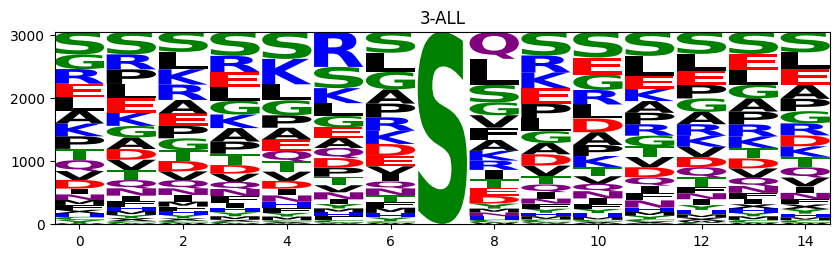

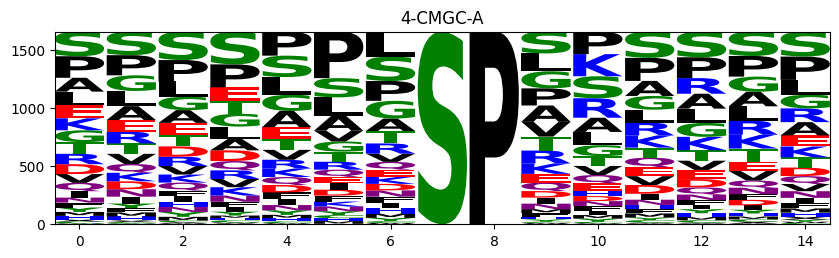

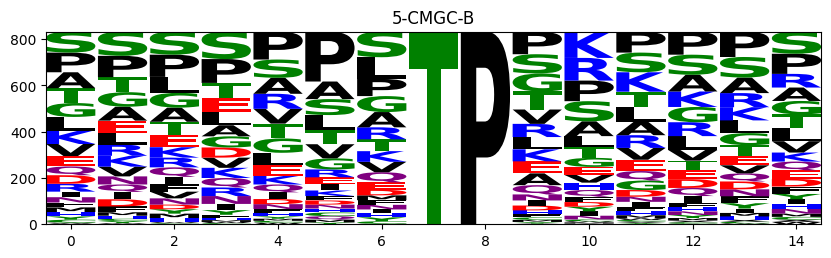

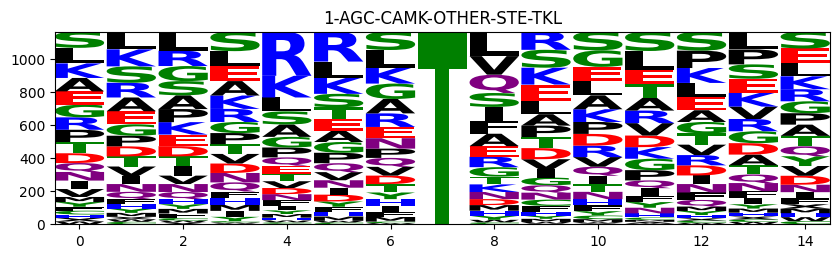

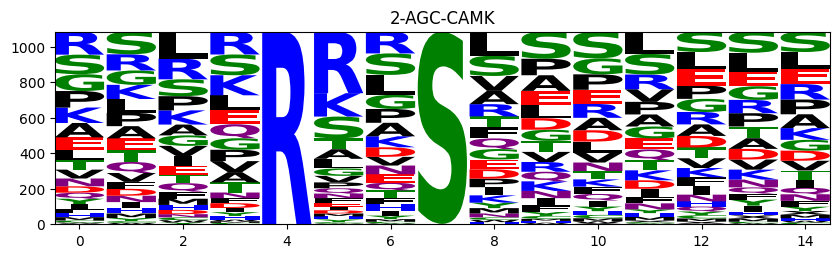

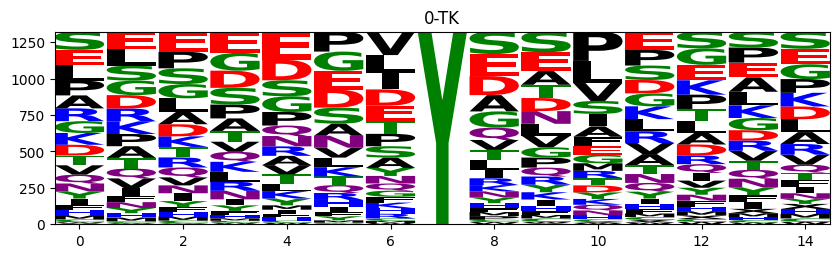

In [86]:
for g in inverted:
    counts_matrix = logomaker.alignment_to_matrix(inverted[g])
    logo = logomaker.Logo(counts_matrix, color_scheme='chemistry')
    plt.title(g)


In [56]:
seqs_to_new_classes['EKVHLTWTKDKSVAE']

KeyError: 'EKVHLTWTKDKSVAE'